# Variational Autoencoder using pytorch
Following the example from: <br>
https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [2]:
# please specify data path
datapath = '../data/MNIST/raw'

In [3]:
train_dataset = torchvision.datasets.MNIST(datapath, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(datapath, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


### Define variational autoencoder
The encoder and decoder networks contain three convolutional layers and two fully connected layers. Some batch normal layers are added to have more robust features in the latent space. Differently from the standard autoencoder, the encoder returns mean and variance matrices and we use them to obtain the sampled latent vector.

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

We define the class that merges the encoder and decoder.

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)
d = 4
vae = VariationalAutoencoder(latent_dims=d).to(device)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

We define the functions to train and evaluate the Variational Autoencoder.

In [9]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

The reconstruction term is the sum of the squared differences between the input and its reconstruction.

In [10]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

Check the input and its corresponding reconstruction in each epoch during the training of the VAE model.

In [11]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

It’s time to finally train the VAE and evaluate in the validation set.

	 partial train loss (single batch): 69447.593750
	 partial train loss (single batch): 67574.328125
	 partial train loss (single batch): 66226.015625
	 partial train loss (single batch): 64600.664062
	 partial train loss (single batch): 63058.441406
	 partial train loss (single batch): 62035.769531
	 partial train loss (single batch): 61601.398438
	 partial train loss (single batch): 60515.320312
	 partial train loss (single batch): 59750.957031
	 partial train loss (single batch): 59503.355469
	 partial train loss (single batch): 58900.957031
	 partial train loss (single batch): 58291.316406
	 partial train loss (single batch): 57762.562500
	 partial train loss (single batch): 57253.226562
	 partial train loss (single batch): 56803.160156
	 partial train loss (single batch): 56325.515625
	 partial train loss (single batch): 56076.226562
	 partial train loss (single batch): 55551.742188
	 partial train loss (single batch): 54940.664062
	 partial train loss (single batch): 54773.046875


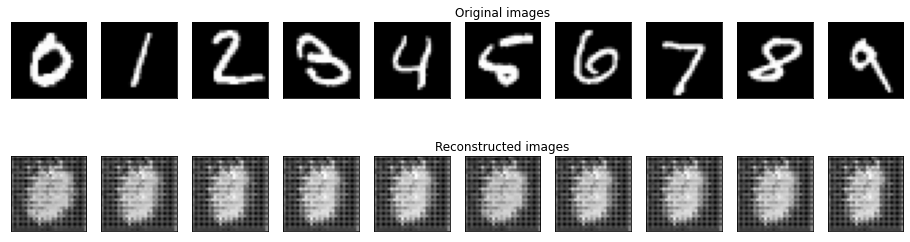

	 partial train loss (single batch): 20066.203125
	 partial train loss (single batch): 20046.863281
	 partial train loss (single batch): 19844.837891
	 partial train loss (single batch): 19862.242188
	 partial train loss (single batch): 19806.914062
	 partial train loss (single batch): 19484.042969
	 partial train loss (single batch): 19421.501953
	 partial train loss (single batch): 19580.738281
	 partial train loss (single batch): 19764.781250
	 partial train loss (single batch): 19232.939453
	 partial train loss (single batch): 19117.320312
	 partial train loss (single batch): 19240.187500
	 partial train loss (single batch): 19165.248047
	 partial train loss (single batch): 19152.294922
	 partial train loss (single batch): 19063.136719
	 partial train loss (single batch): 18878.861328
	 partial train loss (single batch): 18958.029297
	 partial train loss (single batch): 18686.099609
	 partial train loss (single batch): 18888.761719
	 partial train loss (single batch): 18554.208984


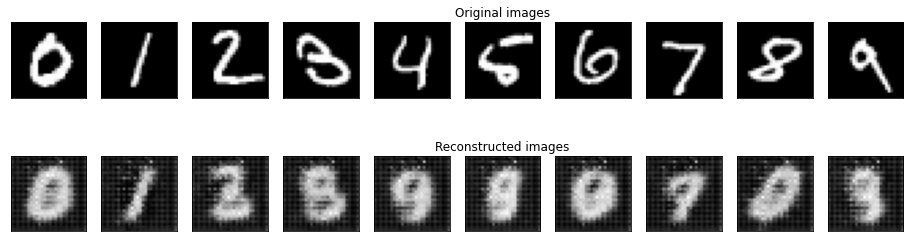

	 partial train loss (single batch): 13365.756836
	 partial train loss (single batch): 13358.340820
	 partial train loss (single batch): 13104.617188
	 partial train loss (single batch): 13242.539062
	 partial train loss (single batch): 13437.702148
	 partial train loss (single batch): 13018.213867
	 partial train loss (single batch): 12763.112305
	 partial train loss (single batch): 13113.337891
	 partial train loss (single batch): 13350.865234
	 partial train loss (single batch): 12846.944336
	 partial train loss (single batch): 12857.216797
	 partial train loss (single batch): 12998.817383
	 partial train loss (single batch): 13007.640625
	 partial train loss (single batch): 12958.449219
	 partial train loss (single batch): 13000.887695
	 partial train loss (single batch): 12789.933594
	 partial train loss (single batch): 13078.953125
	 partial train loss (single batch): 12712.159180
	 partial train loss (single batch): 12902.153320
	 partial train loss (single batch): 12749.836914


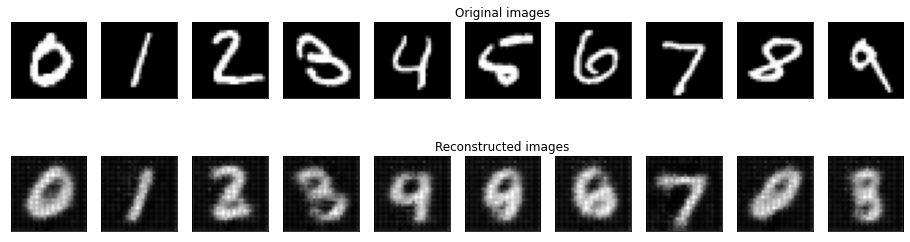

	 partial train loss (single batch): 11026.033203
	 partial train loss (single batch): 10814.256836
	 partial train loss (single batch): 10547.280273
	 partial train loss (single batch): 10800.929688
	 partial train loss (single batch): 11045.350586
	 partial train loss (single batch): 10643.531250
	 partial train loss (single batch): 10427.896484
	 partial train loss (single batch): 10856.735352
	 partial train loss (single batch): 11012.126953
	 partial train loss (single batch): 10644.964844
	 partial train loss (single batch): 10662.436523
	 partial train loss (single batch): 10797.573242
	 partial train loss (single batch): 10821.163086
	 partial train loss (single batch): 10833.741211
	 partial train loss (single batch): 10883.560547
	 partial train loss (single batch): 10626.451172
	 partial train loss (single batch): 10940.257812
	 partial train loss (single batch): 10467.742188
	 partial train loss (single batch): 10982.131836
	 partial train loss (single batch): 10677.166016


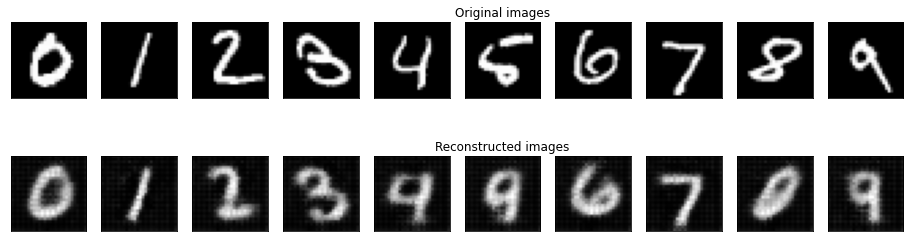

	 partial train loss (single batch): 10194.971680
	 partial train loss (single batch): 9944.927734
	 partial train loss (single batch): 9666.656250
	 partial train loss (single batch): 9942.782227
	 partial train loss (single batch): 10218.667969
	 partial train loss (single batch): 9707.168945
	 partial train loss (single batch): 9546.058594
	 partial train loss (single batch): 10010.507812
	 partial train loss (single batch): 10157.679688
	 partial train loss (single batch): 9864.310547
	 partial train loss (single batch): 9880.212891
	 partial train loss (single batch): 9940.062500
	 partial train loss (single batch): 9978.330078
	 partial train loss (single batch): 10062.527344
	 partial train loss (single batch): 10080.870117
	 partial train loss (single batch): 9702.064453
	 partial train loss (single batch): 10112.949219
	 partial train loss (single batch): 9688.500000
	 partial train loss (single batch): 10201.104492
	 partial train loss (single batch): 9821.150391
	 partial tr

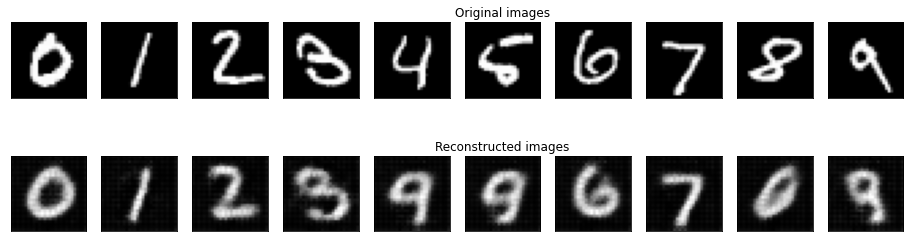

	 partial train loss (single batch): 9760.833984
	 partial train loss (single batch): 9550.672852
	 partial train loss (single batch): 9313.586914
	 partial train loss (single batch): 9505.383789
	 partial train loss (single batch): 9805.015625
	 partial train loss (single batch): 9274.872070
	 partial train loss (single batch): 9137.599609
	 partial train loss (single batch): 9572.664062
	 partial train loss (single batch): 9768.580078
	 partial train loss (single batch): 9412.155273
	 partial train loss (single batch): 9456.520508
	 partial train loss (single batch): 9467.975586
	 partial train loss (single batch): 9530.833008
	 partial train loss (single batch): 9641.570312
	 partial train loss (single batch): 9696.843750
	 partial train loss (single batch): 9288.876953
	 partial train loss (single batch): 9756.657227
	 partial train loss (single batch): 9307.563477
	 partial train loss (single batch): 9852.707031
	 partial train loss (single batch): 9498.494141
	 partial train loss

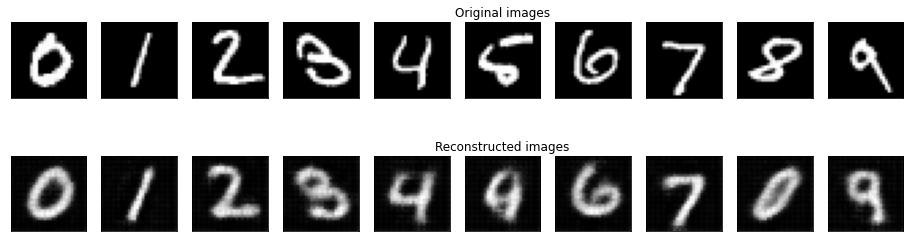

	 partial train loss (single batch): 9558.979492
	 partial train loss (single batch): 9334.954102
	 partial train loss (single batch): 9128.632812
	 partial train loss (single batch): 9267.591797
	 partial train loss (single batch): 9557.636719
	 partial train loss (single batch): 8986.273438
	 partial train loss (single batch): 8844.154297
	 partial train loss (single batch): 9413.581055
	 partial train loss (single batch): 9516.117188
	 partial train loss (single batch): 9150.036133
	 partial train loss (single batch): 9167.292969
	 partial train loss (single batch): 9341.237305
	 partial train loss (single batch): 9299.615234
	 partial train loss (single batch): 9301.080078
	 partial train loss (single batch): 9420.500000
	 partial train loss (single batch): 8976.903320
	 partial train loss (single batch): 9538.092773
	 partial train loss (single batch): 9164.816406
	 partial train loss (single batch): 9544.748047
	 partial train loss (single batch): 9202.903320
	 partial train loss

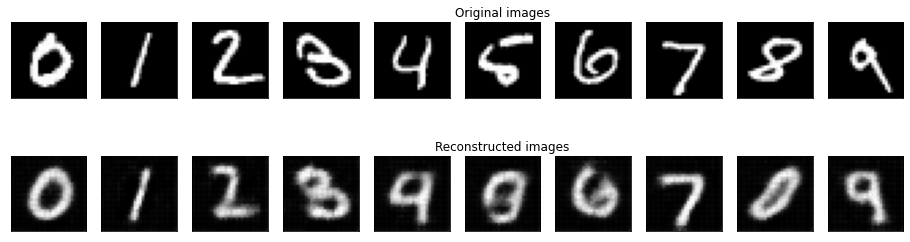

	 partial train loss (single batch): 9388.070312
	 partial train loss (single batch): 9263.263672
	 partial train loss (single batch): 8900.375977
	 partial train loss (single batch): 8997.207031
	 partial train loss (single batch): 9406.589844
	 partial train loss (single batch): 8763.675781
	 partial train loss (single batch): 8758.617188
	 partial train loss (single batch): 9189.832031
	 partial train loss (single batch): 9341.020508
	 partial train loss (single batch): 9049.313477
	 partial train loss (single batch): 9014.731445
	 partial train loss (single batch): 9128.011719
	 partial train loss (single batch): 9114.759766
	 partial train loss (single batch): 9158.833008
	 partial train loss (single batch): 9152.695312
	 partial train loss (single batch): 8831.980469
	 partial train loss (single batch): 9485.923828
	 partial train loss (single batch): 8994.744141
	 partial train loss (single batch): 9405.264648
	 partial train loss (single batch): 9169.622070
	 partial train loss

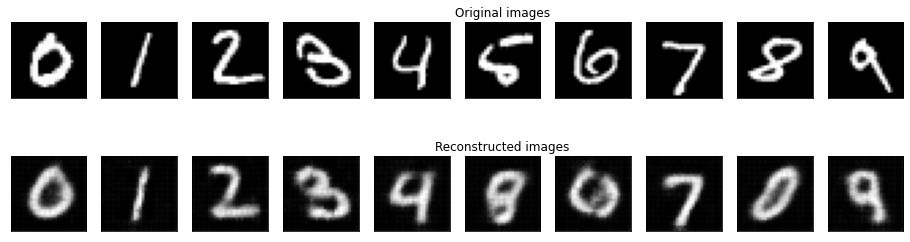

	 partial train loss (single batch): 9259.648438
	 partial train loss (single batch): 9052.437500
	 partial train loss (single batch): 8867.297852
	 partial train loss (single batch): 8892.886719
	 partial train loss (single batch): 9302.013672
	 partial train loss (single batch): 8718.094727
	 partial train loss (single batch): 8585.043945
	 partial train loss (single batch): 9035.342773
	 partial train loss (single batch): 9227.932617
	 partial train loss (single batch): 9015.954102
	 partial train loss (single batch): 8894.787109
	 partial train loss (single batch): 9086.465820
	 partial train loss (single batch): 9000.126953
	 partial train loss (single batch): 9087.725586
	 partial train loss (single batch): 9166.500977
	 partial train loss (single batch): 8782.211914
	 partial train loss (single batch): 9228.583008
	 partial train loss (single batch): 8885.383789
	 partial train loss (single batch): 9361.394531
	 partial train loss (single batch): 9044.454102
	 partial train loss

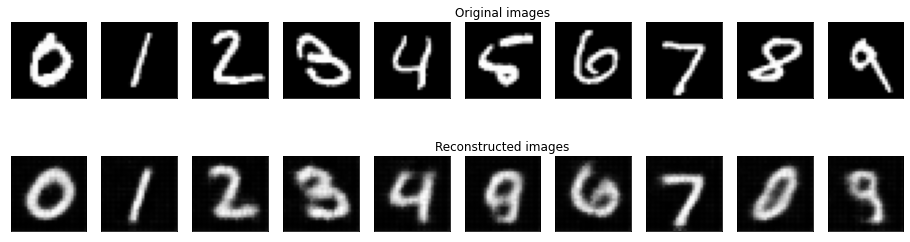

	 partial train loss (single batch): 9116.970703
	 partial train loss (single batch): 8928.024414
	 partial train loss (single batch): 8713.595703
	 partial train loss (single batch): 8716.195312
	 partial train loss (single batch): 9096.367188
	 partial train loss (single batch): 8609.314453
	 partial train loss (single batch): 8555.823242
	 partial train loss (single batch): 8943.734375
	 partial train loss (single batch): 9202.769531
	 partial train loss (single batch): 8820.906250
	 partial train loss (single batch): 8797.029297
	 partial train loss (single batch): 8944.271484
	 partial train loss (single batch): 8998.088867
	 partial train loss (single batch): 8966.418945
	 partial train loss (single batch): 9074.757812
	 partial train loss (single batch): 8661.671875
	 partial train loss (single batch): 9182.732422
	 partial train loss (single batch): 8806.239258
	 partial train loss (single batch): 9244.179688
	 partial train loss (single batch): 8907.137695
	 partial train loss

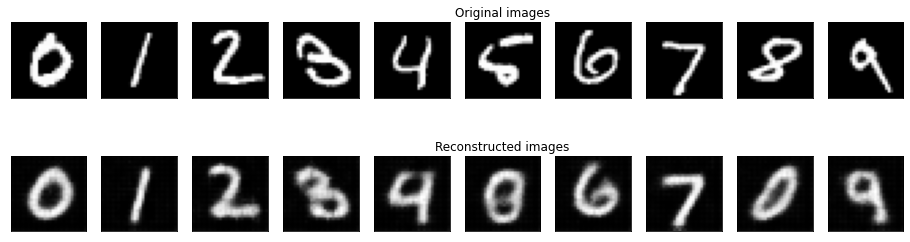

	 partial train loss (single batch): 9009.051758
	 partial train loss (single batch): 8861.242188
	 partial train loss (single batch): 8679.926758
	 partial train loss (single batch): 8730.805664
	 partial train loss (single batch): 9090.888672
	 partial train loss (single batch): 8528.601562
	 partial train loss (single batch): 8462.113281
	 partial train loss (single batch): 8920.929688
	 partial train loss (single batch): 9091.792969
	 partial train loss (single batch): 8774.388672
	 partial train loss (single batch): 8708.670898
	 partial train loss (single batch): 8894.718750
	 partial train loss (single batch): 8909.273438
	 partial train loss (single batch): 8887.100586
	 partial train loss (single batch): 8972.830078
	 partial train loss (single batch): 8599.160156
	 partial train loss (single batch): 9077.371094
	 partial train loss (single batch): 8732.625000
	 partial train loss (single batch): 9151.500977
	 partial train loss (single batch): 8771.866211
	 partial train loss

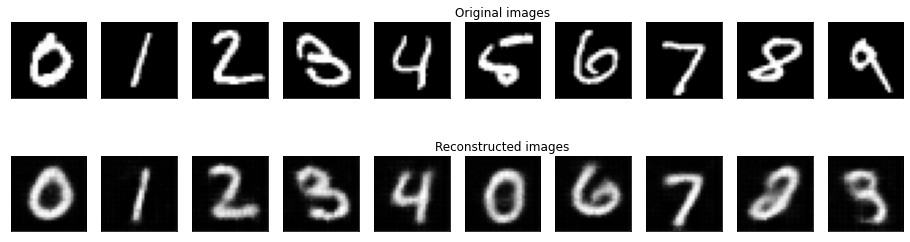

	 partial train loss (single batch): 9006.066406
	 partial train loss (single batch): 8834.450195
	 partial train loss (single batch): 8585.785156
	 partial train loss (single batch): 8656.271484
	 partial train loss (single batch): 9047.515625
	 partial train loss (single batch): 8422.484375
	 partial train loss (single batch): 8416.253906
	 partial train loss (single batch): 8833.672852
	 partial train loss (single batch): 8982.246094
	 partial train loss (single batch): 8733.830078
	 partial train loss (single batch): 8672.781250
	 partial train loss (single batch): 8829.920898
	 partial train loss (single batch): 8769.377930
	 partial train loss (single batch): 8872.228516
	 partial train loss (single batch): 8875.583984
	 partial train loss (single batch): 8532.772461
	 partial train loss (single batch): 9034.307617
	 partial train loss (single batch): 8610.281250
	 partial train loss (single batch): 9100.393555
	 partial train loss (single batch): 8700.682617
	 partial train loss

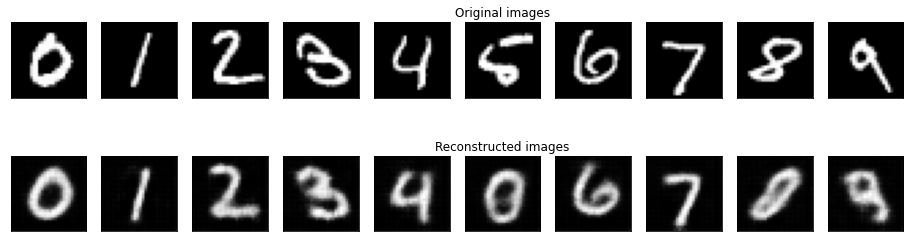

	 partial train loss (single batch): 8948.692383
	 partial train loss (single batch): 8859.427734
	 partial train loss (single batch): 8541.527344
	 partial train loss (single batch): 8598.371094
	 partial train loss (single batch): 8982.552734
	 partial train loss (single batch): 8409.325195
	 partial train loss (single batch): 8422.123047
	 partial train loss (single batch): 8811.597656
	 partial train loss (single batch): 9012.658203
	 partial train loss (single batch): 8675.217773
	 partial train loss (single batch): 8655.876953
	 partial train loss (single batch): 8797.353516
	 partial train loss (single batch): 8753.830078
	 partial train loss (single batch): 8787.958008
	 partial train loss (single batch): 8816.128906
	 partial train loss (single batch): 8459.382812
	 partial train loss (single batch): 8925.888672
	 partial train loss (single batch): 8600.404297
	 partial train loss (single batch): 9053.006836
	 partial train loss (single batch): 8632.329102
	 partial train loss

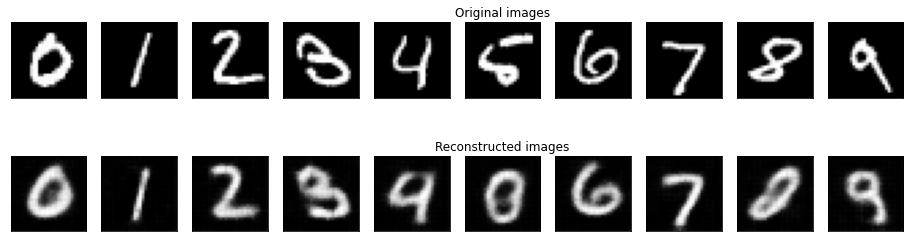

	 partial train loss (single batch): 8811.345703
	 partial train loss (single batch): 8785.014648
	 partial train loss (single batch): 8481.398438
	 partial train loss (single batch): 8589.812500
	 partial train loss (single batch): 8937.081055
	 partial train loss (single batch): 8386.494141
	 partial train loss (single batch): 8327.556641
	 partial train loss (single batch): 8765.936523
	 partial train loss (single batch): 8971.575195
	 partial train loss (single batch): 8551.612305
	 partial train loss (single batch): 8581.181641
	 partial train loss (single batch): 8815.627930
	 partial train loss (single batch): 8726.273438
	 partial train loss (single batch): 8756.574219
	 partial train loss (single batch): 8776.472656
	 partial train loss (single batch): 8454.888672
	 partial train loss (single batch): 8971.635742
	 partial train loss (single batch): 8591.048828
	 partial train loss (single batch): 9039.426758
	 partial train loss (single batch): 8662.075195
	 partial train loss

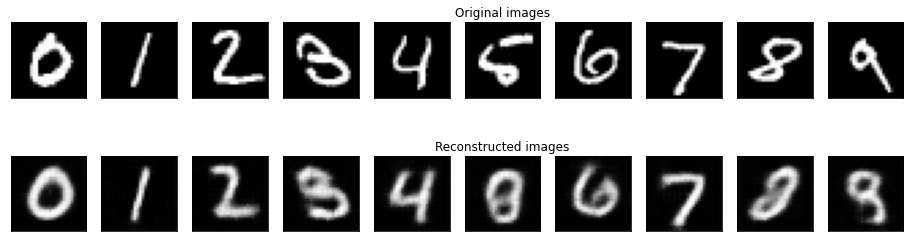

	 partial train loss (single batch): 8937.904297
	 partial train loss (single batch): 8656.996094
	 partial train loss (single batch): 8499.176758
	 partial train loss (single batch): 8497.039062
	 partial train loss (single batch): 8840.246094
	 partial train loss (single batch): 8315.500977
	 partial train loss (single batch): 8304.212891
	 partial train loss (single batch): 8765.269531
	 partial train loss (single batch): 8934.326172
	 partial train loss (single batch): 8495.840820
	 partial train loss (single batch): 8557.208984
	 partial train loss (single batch): 8717.358398
	 partial train loss (single batch): 8713.557617
	 partial train loss (single batch): 8716.195312
	 partial train loss (single batch): 8750.405273
	 partial train loss (single batch): 8454.576172
	 partial train loss (single batch): 8890.810547
	 partial train loss (single batch): 8585.580078
	 partial train loss (single batch): 9060.491211
	 partial train loss (single batch): 8587.467773
	 partial train loss

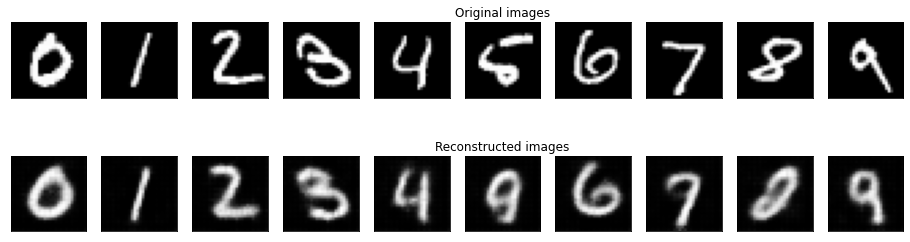

	 partial train loss (single batch): 8795.384766
	 partial train loss (single batch): 8660.021484
	 partial train loss (single batch): 8369.816406
	 partial train loss (single batch): 8547.064453
	 partial train loss (single batch): 8806.095703
	 partial train loss (single batch): 8289.218750
	 partial train loss (single batch): 8260.917969
	 partial train loss (single batch): 8684.741211
	 partial train loss (single batch): 8880.558594
	 partial train loss (single batch): 8538.997070
	 partial train loss (single batch): 8443.635742
	 partial train loss (single batch): 8723.616211
	 partial train loss (single batch): 8693.452148
	 partial train loss (single batch): 8618.493164
	 partial train loss (single batch): 8780.341797
	 partial train loss (single batch): 8373.033203
	 partial train loss (single batch): 8897.443359
	 partial train loss (single batch): 8466.291016
	 partial train loss (single batch): 9039.375977
	 partial train loss (single batch): 8584.043945
	 partial train loss

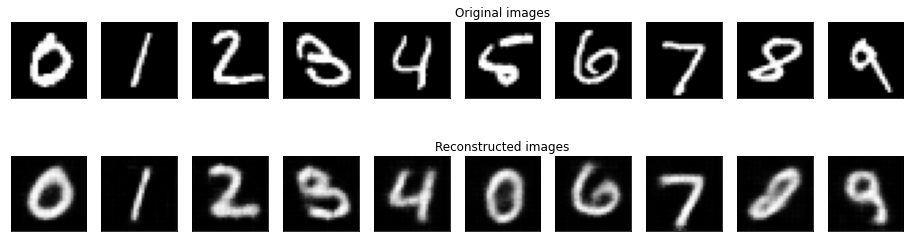

	 partial train loss (single batch): 8752.622070
	 partial train loss (single batch): 8666.223633
	 partial train loss (single batch): 8349.184570
	 partial train loss (single batch): 8454.090820
	 partial train loss (single batch): 8845.375000
	 partial train loss (single batch): 8266.997070
	 partial train loss (single batch): 8215.392578
	 partial train loss (single batch): 8655.216797
	 partial train loss (single batch): 8869.347656
	 partial train loss (single batch): 8506.236328
	 partial train loss (single batch): 8549.193359
	 partial train loss (single batch): 8663.249023
	 partial train loss (single batch): 8643.532227
	 partial train loss (single batch): 8659.126953
	 partial train loss (single batch): 8676.835938
	 partial train loss (single batch): 8379.229492
	 partial train loss (single batch): 8744.159180
	 partial train loss (single batch): 8422.302734
	 partial train loss (single batch): 8958.059570
	 partial train loss (single batch): 8577.264648
	 partial train loss

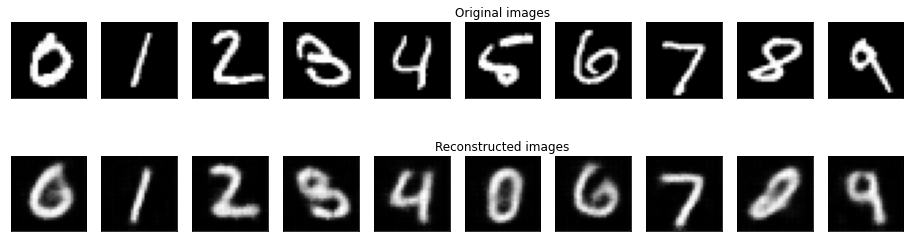

	 partial train loss (single batch): 8771.111328
	 partial train loss (single batch): 8626.462891
	 partial train loss (single batch): 8317.771484
	 partial train loss (single batch): 8415.724609
	 partial train loss (single batch): 8795.493164
	 partial train loss (single batch): 8213.151367
	 partial train loss (single batch): 8233.724609
	 partial train loss (single batch): 8654.122070
	 partial train loss (single batch): 8851.963867
	 partial train loss (single batch): 8574.729492
	 partial train loss (single batch): 8500.747070
	 partial train loss (single batch): 8673.865234
	 partial train loss (single batch): 8578.227539
	 partial train loss (single batch): 8671.482422
	 partial train loss (single batch): 8716.181641
	 partial train loss (single batch): 8362.774414
	 partial train loss (single batch): 8797.291016
	 partial train loss (single batch): 8416.271484
	 partial train loss (single batch): 8946.702148
	 partial train loss (single batch): 8590.951172
	 partial train loss

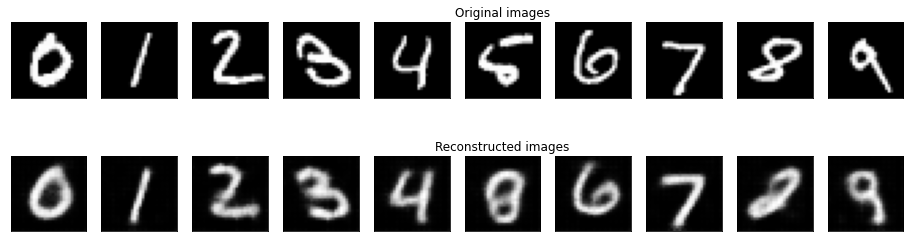

	 partial train loss (single batch): 8699.097656
	 partial train loss (single batch): 8536.136719
	 partial train loss (single batch): 8384.238281
	 partial train loss (single batch): 8453.354492
	 partial train loss (single batch): 8702.691406
	 partial train loss (single batch): 8198.695312
	 partial train loss (single batch): 8145.893555
	 partial train loss (single batch): 8638.974609
	 partial train loss (single batch): 8856.338867
	 partial train loss (single batch): 8479.017578
	 partial train loss (single batch): 8395.318359
	 partial train loss (single batch): 8664.172852
	 partial train loss (single batch): 8574.232422
	 partial train loss (single batch): 8596.754883
	 partial train loss (single batch): 8608.441406
	 partial train loss (single batch): 8283.872070
	 partial train loss (single batch): 8723.100586
	 partial train loss (single batch): 8460.064453
	 partial train loss (single batch): 8876.815430
	 partial train loss (single batch): 8518.493164
	 partial train loss

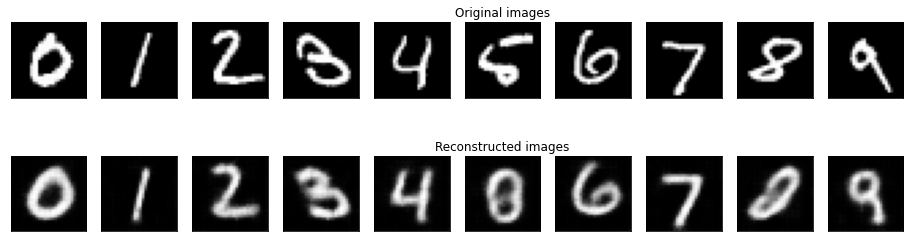

	 partial train loss (single batch): 8708.507812
	 partial train loss (single batch): 8639.240234
	 partial train loss (single batch): 8322.474609
	 partial train loss (single batch): 8399.742188
	 partial train loss (single batch): 8704.779297
	 partial train loss (single batch): 8169.193848
	 partial train loss (single batch): 8148.165039
	 partial train loss (single batch): 8649.091797
	 partial train loss (single batch): 8791.623047
	 partial train loss (single batch): 8358.105469
	 partial train loss (single batch): 8406.279297
	 partial train loss (single batch): 8657.457031
	 partial train loss (single batch): 8621.547852
	 partial train loss (single batch): 8570.799805
	 partial train loss (single batch): 8661.222656
	 partial train loss (single batch): 8334.671875
	 partial train loss (single batch): 8691.632812
	 partial train loss (single batch): 8389.582031
	 partial train loss (single batch): 8864.451172
	 partial train loss (single batch): 8470.210938
	 partial train loss

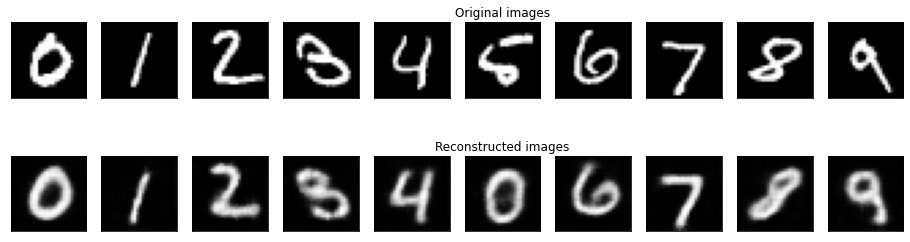

In [12]:
num_epochs = 20

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

To estimate the ability to learn for the Variational Autoencoder, we can also generate new images by drawing latent vectors from the prior distribution, which is normal.

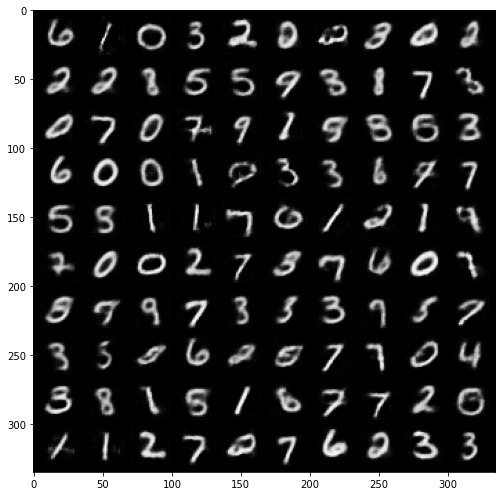

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

We can visualize the latent code learned by the variational decoder and we colour by the ten classes of digits.

In [14]:
encoded_samples = []
for sample in tqdm.tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:03<00:00, 2832.09it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            0.560356        -0.068696        -1.466176         0.550178   
1           -0.820843        -0.794148         1.702749         1.055436   
2            0.571669         0.144425         0.421754         1.596613   
3           -0.087137        -0.328845         0.161579        -1.056817   
4           -0.253724        -0.560982        -0.700114        -0.417863   
...               ...              ...              ...              ...   
9995        -0.318048        -0.622262         1.264880        -0.187299   
9996        -1.348769         0.446916         0.946667         0.279106   
9997         0.521774        -0.266881        -0.383143         0.196544   
9998         0.896428         1.403940        -0.128048        -0.386818   
9999         0.201103        -1.015255         0.153323        -1.221127   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [15]:
from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

A better visualization can be obtained applying the t-SNE, a reduction dimensionality method. With two components, I can visualize the latent code.

In [16]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/home/yangliu/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/yangliu/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

